# Rotated Object Detection

In this tutorial, you will learn:
- the basic structure of Oriented R-CNN.
- to perform inference with a MMRotate detector.
- to perform inference on huge image.

Let's start!


## Install MMRotate

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# Install mmdetection
!pip install mmdet

# Install mmrotate
!rm -rf mmrotate
!git clone https://github.com/open-mmlab/mmrotate.git
%cd mmrotate
!pip install -e .

# switch branch
!git checkout dev
!git branch -a

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.3 MB/s eta 0:15:30tcmalloc: large alloc 1147494400 bytes == 0x5618b075e000 @  0x7fc1543ce615 0x56187631e3bc 0x5618763ff18a 0x5618763211cd 0x561876413b3d 0x561876395458 0x56187639002f 0x561876322aba 0x5618763952c0 0x56187639002f 0x561876322aba 0x561876391cd4 0x561876414986 0x561876391350 0x561876414986 0x561876391350 0x561876414986 0x561876391350 0x561876322f19 0x561876366a79 0x561876321b32 0x5618763951dd 0x56187639002f 0x561876322aba 0x561876391cd4 0x56187639002f 0x561876322aba 0x561876390eae 0x5618763229da 0x561876391108 0x56187639002f
     |████████████████▌               | 1055.7 MB 1.2 MB/s eta 0:13:13tcmalloc: large alloc 1434370048 bytes == 0x5618f4db4000 @  0x7fc1543ce615 0x56187631e3bc 0x5618763ff18a 0x5618763211cd 0x561876413b3d 0x561876395458 0x56187639002f 0x561876322aba 0x5618763952c0 0x56187639002f 0x561876322aba 0x561876391cd4 0x561876414986 0x5618763913

In [3]:
from mmcv import collect_env
collect_env()

{'CUDA available': True,
 'CUDA_HOME': '/usr/local/cuda',
 'GCC': 'gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0',
 'GPU 0': 'Tesla T4',
 'MMCV': '1.4.6',
 'MMCV CUDA Compiler': '11.1',
 'MMCV Compiler': 'GCC 7.3',
 'NVCC': 'Build cuda_11.1.TC455_06.29190527_0',
 'OpenCV': '4.1.2',
 'PyTorch': '1.9.0+cu111',
 'PyTorch compiling details': 'PyTorch built with:\n  - GCC 7.3\n  - C++ Version: 201402\n  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications\n  - Intel(R) MKL-DNN v2.1.2 (Git Hash 98be7e8afa711dc9b66c8ff3504129cb82013cdb)\n  - OpenMP 201511 (a.k.a. OpenMP 4.5)\n  - NNPACK is enabled\n  - CPU capability usage: AVX2\n  - CUDA Runtime 11.1\n  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86\n  - CuDNN 

In [4]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMRotate installation
import mmrotate
print(mmrotate.__version__)

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.9.0+cu111 True
0.1.0
2.22.0
11.1
GCC 7.3


## Perform Inference with An MMRotate detector



### A two-stage detector

In this tutorial, we use Oriented R-CNN, a simple two-stage detector as an example.

The high-level architecture of Oriented R-CNN is shown in the following picture. More details can be found in the [paper](https://openaccess.thecvf.com/content/ICCV2021/papers/Xie_Oriented_R-CNN_for_Object_Detection_ICCV_2021_paper.pdf).

![oriented rcnn](https://raw.githubusercontent.com/zytx121/image-host/main/imgs/oriented_rcnn.png)


Briefly, it uses a convolutional neural network (CNN) as backbone to extract features from an image. Then, it uses a region proposal network (RPN) to predict proposals, i.e., potential objects. After that, it uses `RoIAlignRotated` to crop rotated features for the region of interests (RoI), and uses a RoI Head to perform classification and bounding box prediction.



In [5]:
# We download the pre-trained checkpoints for inference and finetuning.
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmrotate/v0.1.0/oriented_rcnn/oriented_rcnn_r50_fpn_1x_dota_le90/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth \
      -O checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth

--2022-03-05 12:50:42--  https://download.openmmlab.com/mmrotate/v0.1.0/oriented_rcnn/oriented_rcnn_r50_fpn_1x_dota_le90/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.186.233
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.186.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 165749436 (158M) [application/octet-stream]
Saving to: ‘checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth’

checkpoints/oriente 100%[===================>] 158.07M  12.6MB/s    in 13s     

2022-03-05 12:50:56 (12.4 MB/s) - ‘checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth’ saved [165749436/165749436]



In [6]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

# Choose to use a config and initialize the detector
config = 'configs/oriented_rcnn/oriented_rcnn_r50_fpn_1x_dota_le90.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth'

# Set the device to be used for evaluation
device='cuda:0'

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

/usr/local/lib/python3.7/dist-packages/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '


load checkpoint from local path: checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth


OrientedRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

From the printed model, we will find that the model does consist of the components that we described earlier. It uses ResNet as its CNN backbone, and has a RPN head and RoI Head. In addition, the model has a neural network module, named neck, directly after the CNN backbone. It is a [feature pyramid network (FPN)](https://arxiv.org/abs/1612.03144) for enhancing the multi-scale features.


### Inference the detector

Since the model is successfully created and loaded, let's see how good it is. We use the high-level API `inference_detector` implemented in the MMDetection. This API is created to ease the inference process. The details of the codes can be found [here](https://github.com/open-mmlab/mmdetection/blob/master/mmdet/apis/inference.py#L15).

In [7]:
# Use the detector to do inference
img = 'demo/demo.jpg'
result = inference_detector(model, img)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '


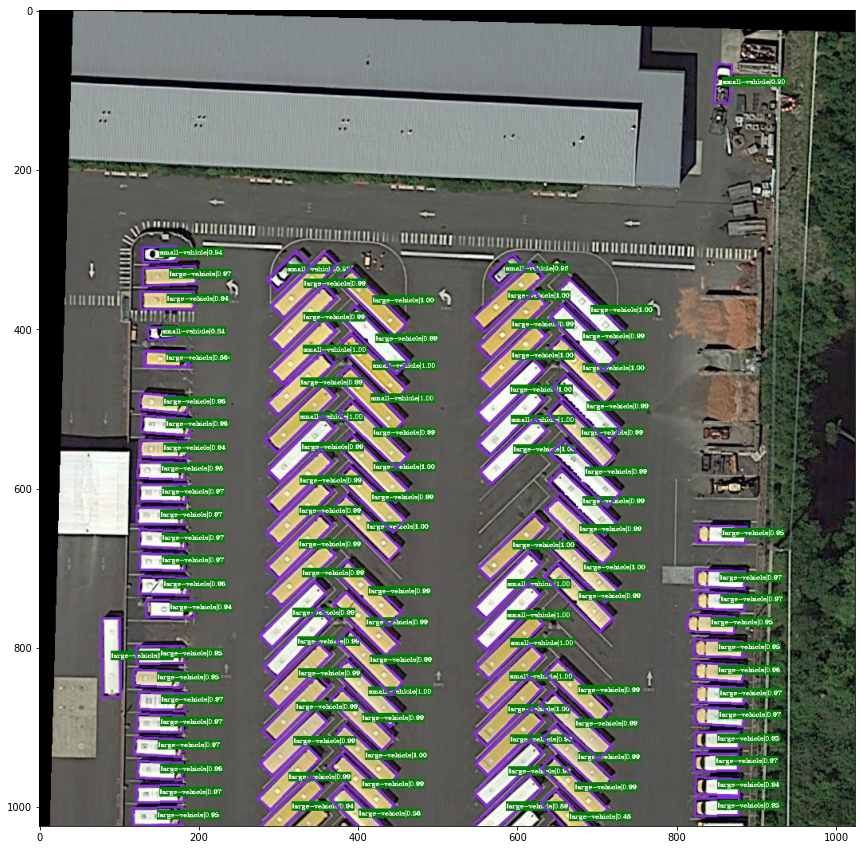

In [8]:
# Let's plot the result
import mmcv
import matplotlib.pyplot as plt

model.show_result(img, result, score_thr=0.3, out_file='./det.jpeg')
img = mmcv.imread('./det.jpeg')
plt.figure(figsize=(20, 15))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

### Inference on huge image
Since small image can be successfully detected, what about huge images in remote sensing? We use the high-level API `inference_detector_by_patches` implemented in the MMRotate. This API is created to ease the inference process for huge image. The details of the codes can be found [here](https://github.com/open-mmlab/mmrotate/blob/dev/mmrotate/apis/inference.py).

In [9]:
# Use the detector to do inference
from mmrotate.apis import inference_detector_by_patches
img = 'demo/dota_demo.jpg'
result = inference_detector_by_patches(model, img, [1024], [824], [1.0], 0.1)

/usr/local/lib/python3.7/dist-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '


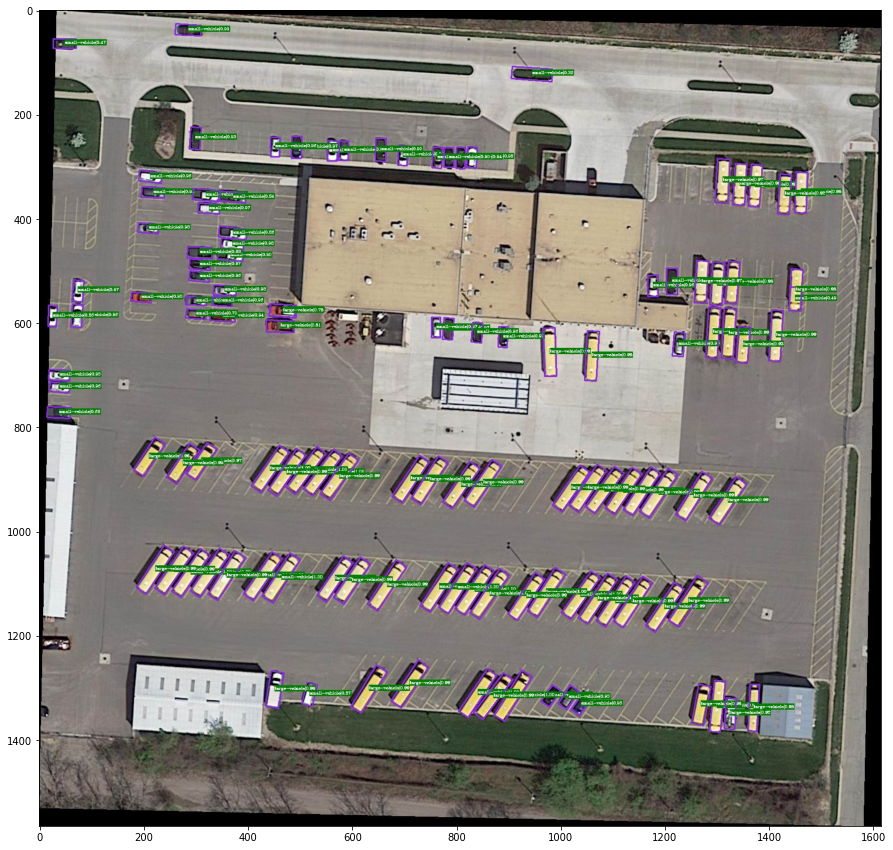

In [10]:
# Let's plot the result
import mmcv
import matplotlib.pyplot as plt

model.show_result(img, result, score_thr=0.3, out_file='./det_huge.jpeg')
img = mmcv.imread('./det_huge.jpeg')
plt.figure(figsize=(20, 15))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

## Train a detector on customized dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



### Support a new dataset

There are three ways to support a new dataset in MMRotate: 
  1. reorganize the dataset into DOTA format.
  2. reorganize the dataset into a middle format.
  3. implement a new dataset.

Usually we recommend to use the first two methods which are usually easier than the third.

In this tutorial, we gives an example that converting the data into the format of existing datasets like DOTA, etc. Other methods and more advanced usages can be found in the [doc](https://mmrotate.readthedocs.io/en/latest/tutorials/customize_dataset.html).

Firstly, let's download a SAR ship dataset obtained from [SSDD](https://github.com/TianwenZhang0825/Official-SSDD). We select the first 193 offshore images and their annotations from the dataset.

In [36]:
# download, decompress the data
# !wget https://download.openmmlab.com/mmrotate/data/ssdd_offshore.zip
!unzip ssdd_tiny.zip

Archive:  ssdd_tiny.zip
   creating: ssdd_tiny/
   creating: ssdd_tiny/labelTxt/
   creating: ssdd_tiny/train/
   creating: ssdd_tiny/val/
  inflating: ssdd_tiny/labelTxt/000001.txt  
  inflating: ssdd_tiny/labelTxt/000009.txt  
  inflating: ssdd_tiny/labelTxt/000011.txt  
  inflating: ssdd_tiny/labelTxt/000029.txt  
  inflating: ssdd_tiny/labelTxt/000041.txt  
  inflating: ssdd_tiny/labelTxt/000049.txt  
  inflating: ssdd_tiny/labelTxt/000051.txt  
  inflating: ssdd_tiny/labelTxt/000059.txt  
  inflating: ssdd_tiny/labelTxt/000061.txt  
  inflating: ssdd_tiny/labelTxt/000071.txt  
  inflating: ssdd_tiny/labelTxt/000079.txt  
  inflating: ssdd_tiny/labelTxt/000081.txt  
  inflating: ssdd_tiny/labelTxt/000089.txt  
  inflating: ssdd_tiny/labelTxt/000091.txt  
  inflating: ssdd_tiny/labelTxt/000099.txt  
  inflating: ssdd_tiny/labelTxt/000101.txt  
  inflating: ssdd_tiny/labelTxt/000109.txt  
  inflating: ssdd_tiny/labelTxt/000111.txt  
  inflating: ssdd_tiny/labelTxt/000119.txt  
  infl

In [37]:
# Check the directory structure of the tiny data

# Install tree first
!apt-get -q install tree
!tree ssdd_tiny

Reading package lists...
Building dependency tree...
Reading state information...
tree is already the newest version (1.7.0-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
ssdd_tiny
├── labelTxt
│   ├── 000001.txt
│   ├── 000009.txt
│   ├── 000011.txt
│   ├── 000029.txt
│   ├── 000041.txt
│   ├── 000049.txt
│   ├── 000051.txt
│   ├── 000059.txt
│   ├── 000061.txt
│   ├── 000071.txt
│   ├── 000079.txt
│   ├── 000081.txt
│   ├── 000089.txt
│   ├── 000091.txt
│   ├── 000099.txt
│   ├── 000101.txt
│   ├── 000109.txt
│   ├── 000111.txt
│   ├── 000119.txt
│   ├── 000121.txt
│   ├── 000129.txt
│   ├── 000131.txt
│   ├── 000139.txt
│   ├── 000141.txt
│   ├── 000149.txt
│   ├── 000151.txt
│   ├── 000159.txt
│   ├── 000161.txt
│   ├── 000169.txt
│   ├── 000171.txt
│   ├── 000179.txt
│   ├── 000181.txt
│   ├── 000189.txt
│   ├── 000191.txt
│   

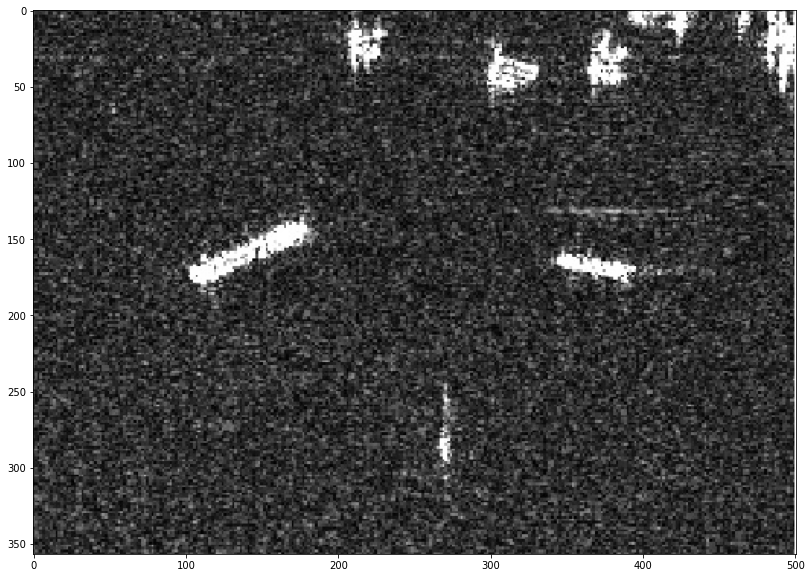

In [38]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('ssdd_tiny/train/000631.png')
plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Let's take a look at the annotation txt file.



In [39]:
# Check the label of a single image
!cat ssdd_tiny/labelTxt/000631.txt

337 169 395 183 398 162 339 154 ship 0
263 273 261 296 276 297 279 272 ship 0
95 165 173 132 184 156 103 186 ship 0


In [40]:
from mmrotate.datasets.builder import ROTATED_DATASETS
from mmrotate.datasets.dota import DOTADataset


@ROTATED_DATASETS.register_module()
class TinyDataset(DOTADataset):
    """SAR ship dataset for detection."""
    CLASSES = ('ship',)

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [41]:
from mmcv import Config
cfg = Config.fromfile('./configs/oriented_rcnn/oriented_rcnn_r50_fpn_1x_dota_le90.py')

Given a config that trains a Oriented R-CNN on DOTA dataset, we need to modify some values to use it for training Oriented R-CNN on SSDD dataset.

In [42]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'TinyDataset'
cfg.data_root = 'ssdd_tiny/'

cfg.data.test.type = 'TinyDataset'
cfg.data.test.data_root = 'ssdd_tiny/'
cfg.data.test.ann_file = 'labelTxt'
cfg.data.test.img_prefix = 'val'

cfg.data.train.type = 'TinyDataset'
cfg.data.train.data_root = 'ssdd_tiny/'
cfg.data.train.ann_file = 'labelTxt'
cfg.data.train.img_prefix = 'train'

cfg.data.val.type = 'TinyDataset'
cfg.data.val.data_root = 'ssdd_tiny/'
cfg.data.val.ann_file = 'labelTxt'
cfg.data.val.img_prefix = 'val'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 1
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.005
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
dataset_type = 'TinyDataset'
data_root = 'ssdd_tiny/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='RResize', img_scale=(1024, 1024)),
    dict(
        type='RRandomFlip',
        flip_ratio=[0.25, 0.25, 0.25],
        direction=['horizontal', 'vertical', 'diagonal'],
        version='le90'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        flip=False,
        transforms=[
            dict(type='RResize'),
            dict(
                type='

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [48]:
import os.path as osp

from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/usr/local/lib/python3.7/dist-packages/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '


AssertionError: ignored

### Understand the log
From the log, we can have a basic understanding the training process and know how well the detector is trained.

Firstly, the ResNet-50 backbone pre-trained on ImageNet is loaded, this is a common practice since training from scratch is more cost. The log shows that all the weights of the ResNet-50 backbone are loaded except the `conv1.bias`, which has been merged into `conv.weights`.

Second, since the dataset we are using is small, we loaded a Oriented R-CNN model and finetune it for detection. 
The original Oriented R-CNN is trained on DOTA dataset which contains 15 classes but SSDD dataset only have 1 classes. Therefore, the last FC layer of the pre-trained Oriented R-CNN for classification has different weight shape and is not used.

Third, after training, the detector is evaluated by the default VOC-style evaluation. The results show that the detector achieves 54.1 mAP on the val dataset,
 not bad!

## Test the trained detector

After finetuning the detector, let's visualize the prediction results!

/usr/local/lib/python3.7/dist-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '


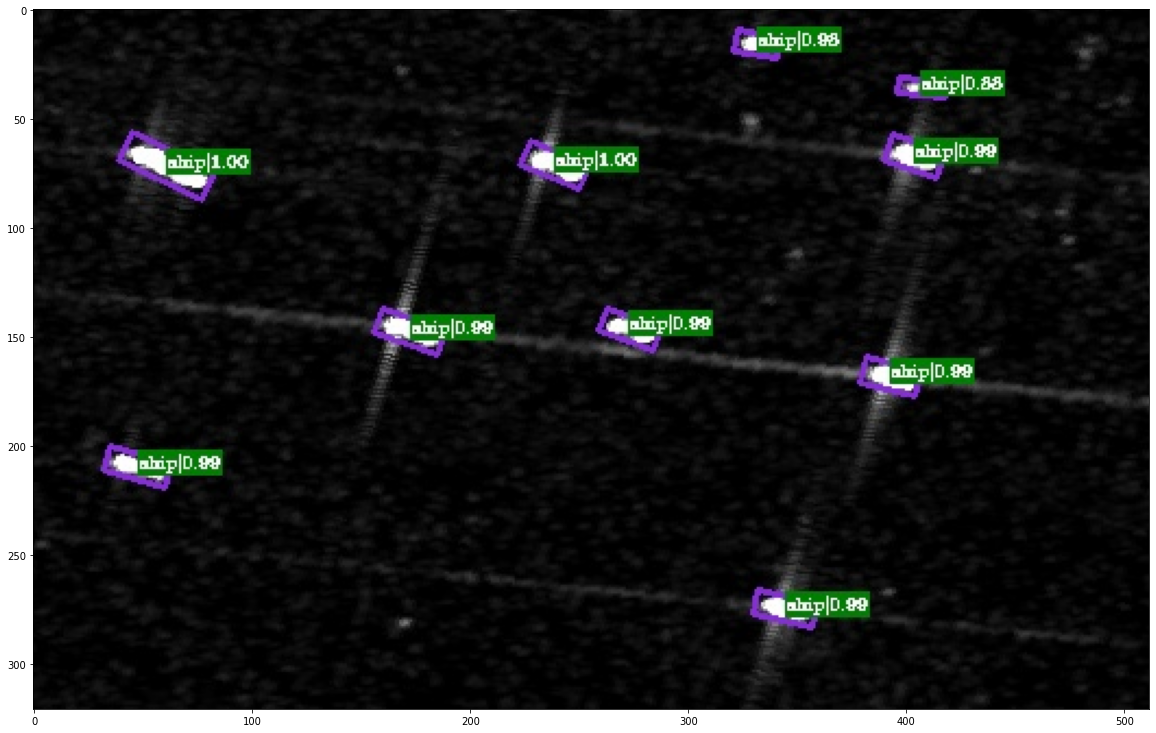

In [34]:
img = mmcv.imread('offshore/images/001129.png')
model.cfg = cfg
result = inference_detector(model, img)
model.show_result(img, result, score_thr=0.3, out_file='./det_ssdd.jpeg')
img = mmcv.imread('./det_ssdd.jpeg')
plt.figure(figsize=(20, 15))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()


## What to Do Next?

So far, we have learnt how to test a two-stage detector using MMRotate. To further explore MMRotate, you could do several other things as shown below:

- Try single-stage detectors, e.g., [Rotated RetinaNet](https://github.com/open-mmlab/mmrotate/tree/dev/configs/rotated_retinanet) and [GWD](https://github.com/open-mmlab/mmrotate/tree/dev/configs/gwd) in [MMRotate model zoo](https://github.com/open-mmlab/mmrotate/blob/dev/docs/en/model_zoo.md). Single-stage detectors are more commonly used than two-stage detectors in industry.
- Try anchor-free detectors, e.g., [Rotated RepPoints](https://github.com/open-mmlab/mmrotate/tree/dev/configs/rotated_reppoints) and [CFA](https://github.com/open-mmlab/mmrotate/tree/dev/configs/cfa) in [MMRotate model zoo](https://github.com/open-mmlab/mmrotate/blob/dev/docs/en/model_zoo.md). Anchor-free detector is a new trend in the object detection community.
